# Training With Regularization

In the previous units, we covered the theory of bias, variance, and different regularization techniques. In this notebook, we will take an experimental approach to learn how to use these concepts to improve our model. We will illustrate the different techniques using the *Fashion MNIST* dataset and the `LambdaLR` scheduler with the `Adam` optimizer.

The techniques that we will be focusing on are:

1. BatchNorm
2. Dropout
3. Data augmentation

<img src="https://opencv.org/wp-content/uploads/2023/05/c4-w4-training-w-regulaization-cover.png">

## Table of Contents


* [1 Training and Dataset Configurations](#1-Training-and-Dataset-Configurations)
* [2 Fashion MNIST Dataset](#2-Fashion-MNIST-Dataset)
* [3 Training and Validation Helper functions](#3-Training-and-Validation-Helper-functions)
* [4 Optimizer and Scheduler](#4-Optimizer-and-Scheduler)
* [5 Main Function For Training](#5-Main-Function-For-Training)
* [6 Model 1 - Small Model [S]](#6-Model-1---Small-Model-[S])
    * [6.1 Perform Overfitting Check](#6.1-Perform-Overfitting-Check)
    * [Experiment 1 - Without Regularization [S]](#6.2-Experiment-1---Without-Regularization-[S])
* [7 Model 2 - Medium Model [M]](#7-Model-2---Medium-Model-[M])
    * [7.1 Perform Overfitting Check](#7.1-Perform-Overfitting-Check)
    * [Experiment 2 - Without Regularization [M]](#7.1-Experiment-2---Without-Regularization-[M])
    * [Experiment 3 - With Only Batch-Normalization [M]](#7.2-Experiment-3---With-Only-Batch-Normalization-[M])
    * [Experiment 4 - With Only Spatial-Dropout [M]](#7.3-Experiment-4---With-Only-Spatial-Dropout-[M])
    * [Experiment 5 - With Batch-Norm and Dropout [M]](#7.4-Experiment-5---With-Batch-Norm-and-Dropout-[M])
    * [Experiment 6 - With Only Data Augmentation [M]](#7.5-Experiment-6---With-Only-Data-Augmentation-[M])
    * [Experiment 7 - Data Augmentation with Batch-Norm and Dropout [M]](#7.6-Experiment-7---Data-Augmentation-with-Batch-Norm-and-Dropout-[M])
* [8 Model 3 - Large Model [L]](#8-Model-3---Large-Model-[L])
    * [8.1 Perform Overfitting Check](#8.1-Perform-Overfitting-Check)
    * [Experiment 8: Data Augmentation With Batch-Norm and Dropout [L]](#8.2-Experiment-8:-Data-Augmentation-With-Batch-Norm-and-Dropout-[L])
* [9 Plotting Accuracy & Loss Curves](#9-Plotting-Accuracy-&-Loss-Curves)
* [10 Conclusion](#10-Conclusion)

**We will perform the following experiments:**

***Experiment 1 - Using a Small Model:***
 - Start with a small CNN (**`SmallModel` \[S\]**), reaching a training accuracy of `≈95%`. Note that if the training accuracy is not very high, the model is not complex enough to overfit (get almost 100% accuracy on training data or around zero loss on training data). Going by the definition of bias and variance, this model has high bias and variance.

---
---

***Define a new Medium Model:*** We need a deeper and wider model. Accordingly, we create one bigger model, i.e., (**`MediumModel` \[M\]**). Also, to conduct all our experiments, this model must be configurable such that we can specify options on whether we want to use batch-norm, dropout, etc.

***Experiment 2 - Using a Medium Model with No Regularization:***

- First, we will train the `MediumModel` without regularization (no Dropout,  Batch Norm, Data augmentation, LR Scheduler, or L2-penalty). We find that that model overfits (`100%` training accuracy, but has only `92-93%` for validation). This model has low bias and high variance. We, therefore, need to use regularization techniques to reduce this high variance.


***Experiment 3 - Using a Medium Model with only Batch Normalization:***

- In this experiment, we will add "BatchNorm2d" layers to the feature extractor part of the model. You will notice that the validation accuracy improves, as well as the loss decreases. Even if accuracy does not improve and only the loss decreases, it still means this is a more robust model (misclassification confidence will not be very high).


***Experiment 4 - Using a Medium Model with only Dropout Regularization:***

- Instead of batch norm layers, we will use `Dropout2d` for convolutional layers and `Dropout` for linear layers. With the dropout layers, the validation accuracy remains almost the same, but loss improves.

***Experiment 5 - Using a Medium Model with Dropout and Batch Norm Combined:***

- Now, consider Batch Norm with Dropout. In terms of validation accuracy and loss, these cases are slightly better than the ones above.

***Experiment 6 - Using a Medium Model with only Data Augmentation:***

- Next, explore the Data augmentation technique. We will train the model without BatchNorm or Dropout. This run is better than all the experiments above techniques. Why is it so? That's because it is a virtual way to increase the number of training data, which helps in model generalization.

***Experiment 7 - Using a Medium Model with all three techniques:***

- Now, try using both BatchNorm and Dropout with Data augmentation. It works better than all of the above. At the same time, you will notice that train and validation loss decreases till the last epoch. The gap between the two is very tiny. This model has the best generalization ability among all the above experiments.

***Experiment 8 - Using a Large Model with all three techniques:***

- Now that we have reduced the overfitting phenomenon let's try to improve the score. To do this, we create one large complex model ((**LargeModel \[L\]**, by increasing the number of filters and layers) and apply all three regularization techniques as above. Albeit the gap between training and validation is wider, the model achieves the best validation accuracy.

In [ ]:
# # Install libraries and restart kernel.
# !pip install -qU albumentations torchmetrics livelossplot torchinfo tqdm

In [ ]:
import os
import gc
import math
import warnings
from dataclasses import dataclass
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import cross_entropy

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.ops import Conv2dNormActivation


from tqdm import tqdm
from torchinfo import summary
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)


# For plotting training and validation metrics.
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot, ExtremaPrinter

import torch._dynamo
torch._dynamo.config.suppress_errors = True

%matplotlib inline
warnings.filterwarnings(action='ignore', category=UserWarning)

# Text formatting
BOLD = "\033[1m"
END = "\033[0m"

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def get_default_device():
    gpu_available = torch.cuda.is_available()
    return torch.device('cuda' if gpu_available else 'cpu'), gpu_available

## 1 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class DatasetConfig:
    HEIGHT:      int = 28
    WIDTH:       int = 28
    CHANNELS:    int = 1
    NUM_CLASSES: int = 10
    MEAN:      tuple = (0.2860,)
    STD:       tuple = (0.3530,)
    DATA_ROOT:   str = "data"


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:      int = 128
    NUM_EPOCHS:      int = 60
    LEARNING_RATE: float = 1e-3
    WARMUP_EPOCHS:   int = 10
    DECAY_RATE:    float = 0.1
    NUM_WORKERS:     int = os.cpu_count()

## 2 Fashion MNIST Dataset

The Fashion MNIST dataset is very similar to MNIST handwritten digits dataset, consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

<img src='https://opencv.org/wp-content/uploads/2023/05/c3-w4-fashion-MNIST.png' width=700 align='center'><br/>

In this section, we are defining the `get_data(...)` function. The function definition is the same as previous units. The only difference is that we have a new `data_augmentation` to choose whether to apply augmentation to the training set.

Inside the function, the transformation composition of `train_transforms` depends on the `data_augmentation`'s boolean value.


For data augmentation, we have the following:

- Random Horizontal Flip
- Random Affine (Rotation, translation, zoom)

In [ ]:
def get_data(resize_to=(32, 32), batch_size=32, pin_memory=False, data_root="data", num_workers=0, data_augmentation=False):

    # Dataset mean and std.
    MEAN, STD = DatasetConfig.MEAN, DatasetConfig.STD

    common_transforms = transforms.Compose([
        transforms.Resize(resize_to),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD),
    ])

    # if data_augmentation is true data augmentation is applied.
    if data_augmentation:
        train_transforms = transforms.Compose([
            transforms.Resize(resize_to),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=(-0.1, 0.1), translate=(0.1, 0.1), scale=(0.95, 1.05)),
            transforms.ToTensor(),
            transforms.Normalize(MEAN, STD)
        ])

    else:
        train_transforms = common_transforms

    # Initialize train dataloader
    train_loader = DataLoader(
        datasets.FashionMNIST(root=data_root, train=True, download=True, transform=train_transforms),
        batch_size=batch_size,
        pin_memory=pin_memory,
        shuffle=True,
        num_workers=num_workers,
    )

    # Initialize valid dataloader
    valid_loader = DataLoader(
        datasets.FashionMNIST(root=data_root, train=False, download=True, transform=common_transforms),
        batch_size=batch_size * 2,
        pin_memory=pin_memory,
        shuffle=False,
        num_workers=num_workers,
    )
    return train_loader, valid_loader

### 2.2 Data Visualization

In [ ]:
# This function is used for reversing the Normalization step performed during image preprocessing.
# Note the mean and std values must match the ones used.

def denormalize(tensors, *, mean, std):
    """Denormalizes image tensors using mean and std provided
    and clip values between 0 and 1"""

    for c in range(DatasetConfig.CHANNELS):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

In [ ]:
def visualize_samples(loader):
    plt.figure(figsize=(18, 8))

    for X, y in loader:
        images = denormalize(X, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).squeeze().numpy()
        target = y.numpy()

        for i in range(8):
            plt.subplot(2, 4, i + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(images[i], cmap="gray")
            plt.xlabel(target[i], fontsize=20)

        plt.suptitle("Dataset Samples", fontsize=18)
        plt.subplots_adjust(wspace=0.2, hspace=0.2)
        plt.show()
        plt.close()

        break

    return

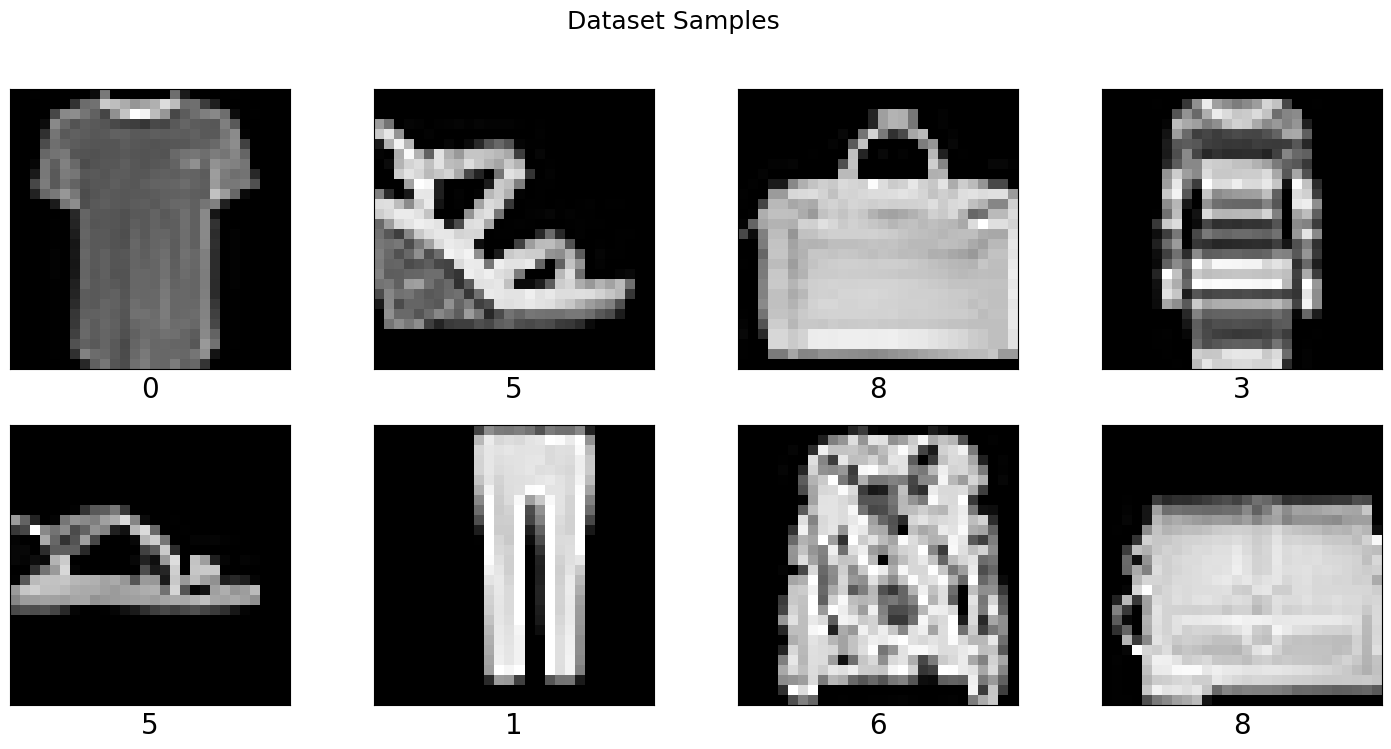

In [ ]:
train_loader, valid_loader = get_data(
    resize_to=(DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
    batch_size=TrainingConfig.BATCH_SIZE,
    data_root=DatasetConfig.DATA_ROOT,
    data_augmentation=True,

)

visualize_samples(train_loader)

## 3 Training and Validation Helper functions

Next, we are defining the `train(...)` and `validate(...)` helper functions. The function definitions remain the same as the previous units.

Both the `train(...)` and `validate(...)` functions utilize the `tqdm` package to generate a progress bar, which visually represents the progress of the training and validation loops. The progress bar displays relevant information such as the current batch loss, accuracy, and learning rate. At the end of each epoch, the progress bar is updated to show the final learning rate, mean loss, and mean accuracy achieved during that epoch.

In [ ]:
def train_one_epoch(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int,
    scheduler: torch.optim.lr_scheduler=None,
):
    # Set model in training mode.
    model.train()

    loss_record = MeanMetric()
    acc_record  = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(train_loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Train :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in train_loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data   = data.to(device)
            target = target.to(device)

            # Record current learning rate.
            lr = optimizer.param_groups[0]['lr'] # As all model parameters were passed during optimizer initialization,
                                                 # they all belong to param_group[0]

            # Reset parameters gradient to zero.
            optimizer.zero_grad()

            # Perform forward pass through the model.
            logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Find gradients w.r.t training parameters.
            loss.backward()

            # Update parameters using gradients.
            optimizer.step()

            if scheduler: # Scheduler step/ update learning rate.
                scheduler.step()

            # Record loss.
            loss_record.update(loss.detach().cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy.
            acc_record.update(pred.cpu(), target.cpu())

            # Update progress bar description with running mean and accuracy values.
            tq.set_postfix_str(s=f"LR: {lr}, Loss: {loss_record.compute():.4f}, Acc: {acc_record.compute():.4f}")

    # Get final loss and accuracy.
    # The values are the same as the one displayed for the final iteration.
    epoch_loss = loss_record.compute()
    epoch_acc  = acc_record.compute()

    return epoch_loss.item(), epoch_acc.item()

In [ ]:
def validate(
    model: nn.Module,
    valid_loader: torch.utils.data.DataLoader,
    device: torch.device,
    num_classes: int,
    epoch_idx: int,
    total_epochs: int
):

    # Set model in evaluation mode.
    model.eval()

    loss_record = MeanMetric()
    acc_record = MulticlassAccuracy(num_classes=num_classes, average="micro")

    loader_len = len(valid_loader)

    with tqdm(total=loader_len, ncols=122, ascii=True) as tq:
        tq.set_description(f"Valid :: Epoch: {epoch_idx}/{total_epochs}")

        for data, target in valid_loader:
            tq.update(1)

            # Send data and target to GPU device if available.
            data     = data.to(device)
            target = target.to(device)

            with torch.no_grad():
                # Perform forward pass through the model.
                logits = model(data)

            # Calculate Cross-entropy loss.
            loss = F.cross_entropy(logits, target)

            # Record loss.
            loss_record.update(loss.cpu(), weight=data.shape[0])

            # Get the index of node with max score.
            pred = torch.argmax(logits, dim=1)

            # Calculate and record accuracy
            acc_record.update(pred.cpu(), target.cpu())

        valid_epoch_loss = loss_record.compute()
        valid_epoch_acc  = acc_record.compute()

        # Update progress bar description to display epoch log.
        tq.set_postfix_str(s=f"Loss: {valid_epoch_loss:.4f}, Acc: {valid_epoch_acc:.4f}")

    return valid_epoch_loss.item(), valid_epoch_acc.item()

## 4 Optimizer and Scheduler

Next, we are defining a `get_optimizer_and_scheduler(...)` helper function,  as we have to use it in all training experiments.

For the LR scheduler, we use a `LambdaLR` scheduler initialized with a custom function to calculate the new learning rate for each epoch.

In [ ]:
def get_optimizer_and_scheduler(model, cuda_available=True, use_scheduler: bool = False):
    # Initialize Optimizer
    optimizer = optim.Adam(
        model.parameters(),
        lr=TrainingConfig.LEARNING_RATE,
        amsgrad=True,
        fused=cuda_available,
    )

    scheduler = None

    if use_scheduler:
        lmbda_fn = lambda epoch: 1 / (1 + TrainingConfig.DECAY_RATE * epoch)

        # Intializing Lambda Scheduler
        scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda_fn)

    return optimizer, scheduler

Visualize the effect of scheduler on the learning rate.

0.00014492753623188405 0.001 0.00014492753623188405


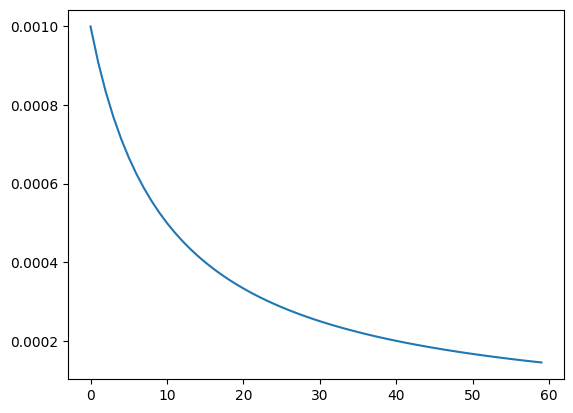

In [ ]:
model = nn.Linear(3, 2)

optimizer, scheduler = get_optimizer_and_scheduler(model, cuda_available=False,use_scheduler= True)

lrs = []
for i in range(TrainingConfig.NUM_EPOCHS):
    lrs.append(scheduler.get_last_lr()[0])
    scheduler.step()

plt.plot(lrs)
print(min(lrs), lrs[0], lrs[-1])

## 5 Main Function For Training

Next, we define the `main(...)` function that contains all the necessary code for training the model.

For this unit, apart from recording per-epoch metrics for training and validation loops. We also use the `PlotLosses` library to render a "live plot" of the training and validation loops. This makes it much easier to visualize the trend during training and validation rather than reading numbers and writing a custom plotting code to visualize after training.

In [ ]:
def main(model, data_augmentation: bool = False, use_scheduler: bool = False):
    # Get accelerator device.
    DEVICE, GPU_AVAILABLE = get_default_device()

    # Intialize train and valid dataloaders.
    train_loader, valid_loader = get_data(
                resize_to = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
               batch_size = TrainingConfig.BATCH_SIZE,
                data_root = DatasetConfig.DATA_ROOT,
               pin_memory = GPU_AVAILABLE,
              num_workers = TrainingConfig.NUM_WORKERS,
        data_augmentation = data_augmentation
    )

    # Send model to DEVICE
    model.to(DEVICE)

    optimizer, scheduler = get_optimizer_and_scheduler(model, cuda_available=GPU_AVAILABLE, use_scheduler=use_scheduler)

    # # # Compile Model.
    # # Uncomment this line if you are using PyTorch 2.0.
    # # Sometimes compilation can also lead to error, do a test run with few epochs
    # # to ensure the code runs without any error. If it doesn't turn off compilation.
    model = torch.compile(model)

    # Accumulate train and valid epoch metrics.
    epoch_train_acc  = []
    epoch_valid_acc  = []
    epoch_train_loss = []
    epoch_valid_loss = []

    # Plot training and validation epoch logs.
    live_plot = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2)), ExtremaPrinter()])

    for epoch in range(TrainingConfig.NUM_EPOCHS):

        # Train for one epoch.
        train_loss, train_acc = train_one_epoch(model, optimizer, train_loader, DEVICE, DatasetConfig.NUM_CLASSES, epoch+1, TrainingConfig.NUM_EPOCHS, scheduler=None)

        # Perform validation run.
        valid_loss, valid_acc = validate(model, valid_loader, DEVICE, DatasetConfig.NUM_CLASSES, epoch+1, TrainingConfig.NUM_EPOCHS)

        # Update learning rate if scheduler is used.
        if scheduler:
            scheduler.step()

        # Collect loss and accuracy
        epoch_train_loss.append(train_loss)
        epoch_valid_loss.append(valid_loss)
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)

        # Plot train and validation statistics.
        live_plot.update({
                    "loss": train_loss,
                "val_loss": valid_loss,
                "accuracy": train_acc,
            "val_accuracy": valid_acc,
        })

        live_plot.send()


    # Cleanup
    del model
    del optimizer
    del train_loader
    del valid_loader

    gc.collect()
    torch.cuda.empty_cache()

    return epoch_train_acc, epoch_train_loss, epoch_valid_acc, epoch_valid_loss

### 5.1 Overfitting Model On Single Training Batch  

We are defining one new function called **`overfit_one_batch(...)`**. The function definition of this function is a lot similar to the `main(...)` method. The only difference is that rather than looping on the entire dataset, we use just one shuffled batch of training data with no augmentations applied to train the model to understand if the `model` used can learn the dataset.  

This function can be merged with the `main(...)` method, and the `get_data(...)` function can also be updated to handle this scenario. But we chose to keep this functionality different to ensure the code is easy to read and understand.

In [ ]:
def overfit_one_batch(model, total_epochs=100):

    # Get accelerator device.
    DEVICE, GPU_AVAILABLE = get_default_device()

    # Intialize train and valid dataloaders.
    train_loader, _ = get_data(
                resize_to = (DatasetConfig.HEIGHT, DatasetConfig.WIDTH),
               batch_size = TrainingConfig.BATCH_SIZE,
                data_root = DatasetConfig.DATA_ROOT,
               pin_memory = GPU_AVAILABLE,
              num_workers = TrainingConfig.NUM_WORKERS,
        data_augmentation = False
    )

    # Get 1 batch of training data.
    data, target = next(iter(train_loader))

    # Send model, data and target to acceleration device.
    model.to(DEVICE)
    data = data.to(DEVICE)
    target = target.to(DEVICE)

    # Intialize Optimizer.
    optimizer, _ = get_optimizer_and_scheduler(model, use_scheduler=False)

    loss_record = []
    acc_record  = []

    for epoch in range(1, total_epochs+1):

        logits = model(data)                 # Perform forward pass through the model.
        optimizer.zero_grad()                # Reset parameters gradient to zero.
        loss = cross_entropy(logits, target) # Calculate Cross-entropy loss.
        loss.backward()                      # Find gradients w.r.t training parameters.
        optimizer.step()                     # Update parameters using gradients.

        # Record current loss value.
        loss_value = loss.detach().item()
        loss_record.append(loss_value)

        # Calculate and record current accuracy value.
        acc_value = torch.sum(logits.detach().argmax(dim=1) == target) / target.shape[0]
        acc_record.append(acc_value.item())

        # Print logs.
        clear_output(wait=True)
        print(f"{BOLD}{'Epoch':^10}{END}|{BOLD}{'Loss':^15}{END}|{BOLD}{'Acc':^10}{END}")
        print(f"{'':=^35}")
        print(f"{epoch:^10}|{loss_value:^15.8f}|{acc_value:^10.3f}")


    # Plot training loss and accuracy.
    plt.plot(loss_record)
    plt.plot(acc_record)
    plt.title("Overfitting On A Single Batch")
    plt.legend(["loss", "Accuracy"])
    plt.xlabel("Epochs")
    plt.ylabel("Train Loss and Accuracy")
    plt.show();
    print(f"Mean loss: {np.mean(loss_record)}, Min loss: {min(loss_record)}")

    # Cleanup
    del train_loader
    del data
    del target
    del model
    del optimizer
    del loss_record
    del acc_record

    gc.collect()
    torch.cuda.empty_cache()

    return

## 6 Model 1 - Small Model [S]

A smaller model compared to the `LeNet` Network, let’s check out how much it can learn!

In [ ]:
def small_model(in_channels=1, num_classes=10):
    model = nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=4, kernel_size=5),

        # ReLU --> MaxPool == MaxPool --> ReLU
        # In this way, ReLU which is applied to each pixel has
        # is faster because the feature map has been shrinked.
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(inplace=True),

        nn.Flatten(),

        nn.Linear(in_features=8 * 5 * 5, out_features=100),
        nn.ReLU(inplace=True),

        nn.Linear(in_features=100, out_features=50),
        nn.ReLU(inplace=True),

        nn.Linear(in_features=50, out_features=num_classes)
    )
    return model

In [ ]:
model = small_model(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES)

# Print model summary
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 4, 24, 24]            104
├─MaxPool2d: 1-2                         [1, 4, 12, 12]            --
├─ReLU: 1-3                              [1, 4, 12, 12]            --
├─Conv2d: 1-4                            [1, 8, 10, 10]            296
├─MaxPool2d: 1-5                         [1, 8, 5, 5]              --
├─ReLU: 1-6                              [1, 8, 5, 5]              --
├─Flatten: 1-7                           [1, 200]                  --
├─Linear: 1-8                            [1, 100]                  20,100
├─ReLU: 1-9                              [1, 100]                  --
├─Linear: 1-10                           [1, 50]                   5,050
├─ReLU: 1-11                             [1, 50]                   --
├─Linear: 1-12                           [1, 10]                   510
Total

### 6.1 Perform Overfitting Check

* [x] Regularization turned off
* [x] Loss going Down
* [x] Overfitting on Single Batch

  Epoch   |     Loss      |   Acc    
   500    |  0.00061508   |  1.000   


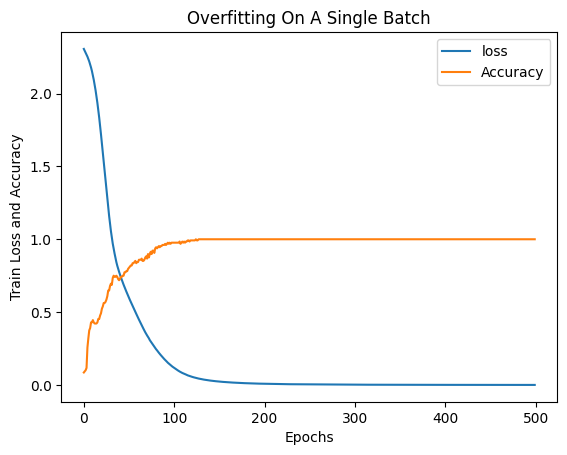

Mean loss: 0.18296493715432008, Min loss: 0.000615080411080271


In [ ]:
overfit_one_batch(model, total_epochs=500)

### 6.2 Experiment 1 - Without Regularization [S]

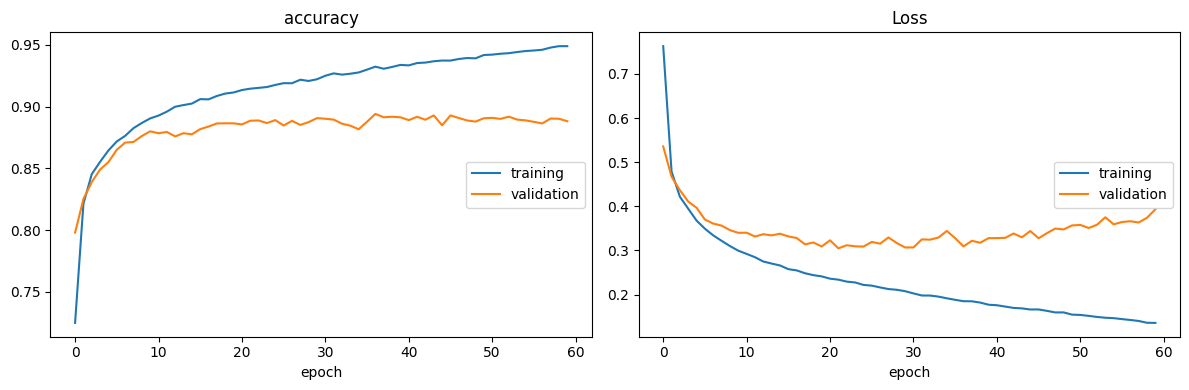

accuracy
	training         	 (min:    0.725, max:    0.949, cur:    0.949)
	validation       	 (min:    0.798, max:    0.894, cur:    0.888)
Loss
	training         	 (min:    0.136, max:    0.763, cur:    0.136)
	validation       	 (min:    0.305, max:    0.536, cur:    0.393)


In [ ]:
seed_everything(41)

model = small_model(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES)

# Train the model.
train_acc_exp1, train_loss_exp1, valid_acc_exp1, valid_loss_exp1 = main(model, data_augmentation=False, use_scheduler=False)

The model has reached it's learning capacity and if we train the model any further, the "overfitting gap" (train and validation loss diverging) will continue to increase.

## 7 Model 2 - Medium Model [M]

Next, we use a new `MediumModel`, which is bigger (in terms of parameters) than the previous one.

The function contains parameters such as `use_batch_norm`, `use_spatial_dropout`, and `use_combined`. These three boolean flags define three different "feature extractor" of the CNN.

1. With the `use_batch_norm` flag, the extractor contains batch-normalization layers. We define the Conv-block (i.e., Conv-BatchNorm-ReLU) using the `Conv2dNormActivation` layer in the `torchvision.ops` package.

2. With the `use_spatial_dropout`flag, we define a network that instead of batch-normalization uses `Dropout2d` or commonly known as *`SpatialDropout`* for regularization.

3. With the `use_combined` flag, we define a feature extractor that uses batch normalization in the first two blocks and spatial dropout in the next two.


We use this definition to see the effects of overfitting and regularization.

---

**Note:** One additional change you can try with is by replacing the final maxpooling layer of the feature with `nn.AdaptiveAvgPool2d(output_size=(1, 1))` layer. This layer is also known as *Global Average Pooling* (GAP). Here, it won't have much affect because the input feature map size is already very small.

**Global Average Pooling** is a pooling operation commonly used in convolutional neural networks (CNNs) for feature extraction. Unlike traditional pooling methods like max pooling or average pooling, which operate on local regions within feature maps, global average pooling involves taking the average of each feature map along its spatial dimensions, resulting in a single value per feature map. This operation effectively collapses the spatial information while preserving the channel-wise information, reducing the dimensionality of the feature maps. Global average pooling is typically applied to these feature maps to obtain a compact and fixed-length representation of the features.

Advantage:

1. Provides a spatial-invariant representation, making the network more robust to spatial translations or distortions in the input data.
2. Reduces the number of parameters in the network, which can help prevent overfitting and improve generalization.

In [ ]:
class MediumModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=10,
                 use_batch_norm=False, use_spatial_dropout=False, use_combined=False,
                 spatial_dropout_rate=0.2, dropout_rate=0.3):
        super().__init__()

        layers = []

        # convolution layers
        if use_batch_norm:
            layers.extend([
                Conv2dNormActivation(in_channels=in_channels, out_channels=64, kernel_size=3, padding='same'),
                nn.MaxPool2d(kernel_size=2),

                Conv2dNormActivation(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
                nn.MaxPool2d(kernel_size=2),

                Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
                nn.MaxPool2d(kernel_size=2),

                Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
                nn.MaxPool2d(kernel_size=2)
            ])

        elif use_spatial_dropout:
            layers.extend([
                nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=spatial_dropout_rate),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=spatial_dropout_rate),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=spatial_dropout_rate),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=spatial_dropout_rate),
                nn.MaxPool2d(kernel_size=2),
            ])

        elif use_combined:
            layers.extend([
                Conv2dNormActivation(in_channels=in_channels, out_channels=64, kernel_size=3, padding='same'),
                nn.MaxPool2d(kernel_size=2),

                Conv2dNormActivation(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=spatial_dropout_rate),
                nn.MaxPool2d(kernel_size=2),

                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
                nn.ReLU(inplace=True),
                nn.Dropout2d(p=spatial_dropout_rate),
                nn.MaxPool2d(kernel_size=2),
            ])


        layers.extend([
            # # Global Average pooling layer not used.
            # nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),

            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),

            nn.Linear(in_features=128, out_features=num_classes)
        ])

        self._model = nn.Sequential(*layers)


    def forward(self, x):
        return self._model(x)

In [ ]:
# Defining a model with no regularization used.
model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_spatial_dropout=True, spatial_dropout_rate=0.0, dropout_rate=0.0)

# Printing model summary
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
MediumModel                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Dropout2d: 2-3                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          73,856
│    └─ReLU: 2-6                         [1, 128, 14, 14]          --
│    └─Dropout2d: 2-7                    [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-8                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-9                       [1, 256, 7, 7]            295,168
│    └─ReLU: 2-10                        [1, 256, 7, 7]            --
│    └─Dropout2d: 2-11                   [1, 256, 7, 7]            --
│    

### 7.1 Perform Overfitting Check

* [x] Regularization turned off
* [x] Loss going Down
* [x] Overfitting on Single Batch

  Epoch   |     Loss      |   Acc    
   500    |  0.00006862   |  1.000   


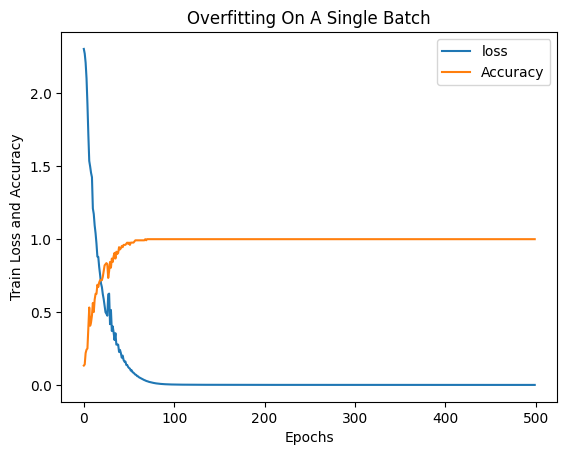

Mean loss: 0.08066704668877356, Min loss: 6.861950532766059e-05


In [ ]:
overfit_one_batch(model, total_epochs=500)

### 7.1 Experiment 2 - Without Regularization [M]

In the first experiment with the Medium model,  "no regularization" is applied to train the model.

As we can see from the learning plots, the model quickly overfits. Still, one thing to note is that validation accuracy and loss are also better than the  Small model.

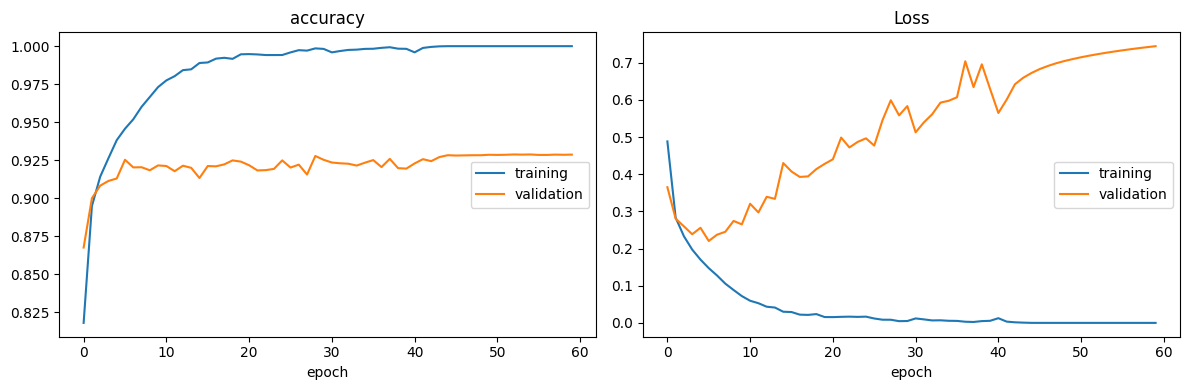

accuracy
	training         	 (min:    0.818, max:    1.000, cur:    1.000)
	validation       	 (min:    0.868, max:    0.929, cur:    0.929)
Loss
	training         	 (min:    0.000, max:    0.488, cur:    0.000)
	validation       	 (min:    0.220, max:    0.745, cur:    0.745)


In [ ]:
seed_everything(41)

model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_spatial_dropout=True, spatial_dropout_rate=0.0, dropout_rate=0.0)

# Train the model with LR scheduler.
train_acc_exp2, train_loss_exp2, valid_acc_exp2, valid_loss_exp2 = main(model, data_augmentation=False, use_scheduler=False)

### 7.2 Experiment 3 - With Only Batch-Normalization [M]

Let's add the **Batch Normalization** layers and check the effects on training.

In [ ]:
# FCN Dropout turned off
model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_batch_norm=True, dropout_rate=0.0)

# Printing model summary
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
MediumModel                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2dNormActivation: 2-1         [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                  [1, 64, 28, 28]           576
│    │    └─BatchNorm2d: 3-2             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-3                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-2                    [1, 64, 14, 14]           --
│    └─Conv2dNormActivation: 2-3         [1, 128, 14, 14]          --
│    │    └─Conv2d: 3-4                  [1, 128, 14, 14]          73,728
│    │    └─BatchNorm2d: 3-5             [1, 128, 14, 14]          256
│    │    └─ReLU: 3-6                    [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-4                    [1, 128, 7, 7]            --
│    └─Conv2dNormActivation: 2-5         [1, 256, 7, 7]            --
│    │  

With the use of LR scheduler and batch normalization, the model still overfits but there's a significant improvement in the validation accuracy and loss.

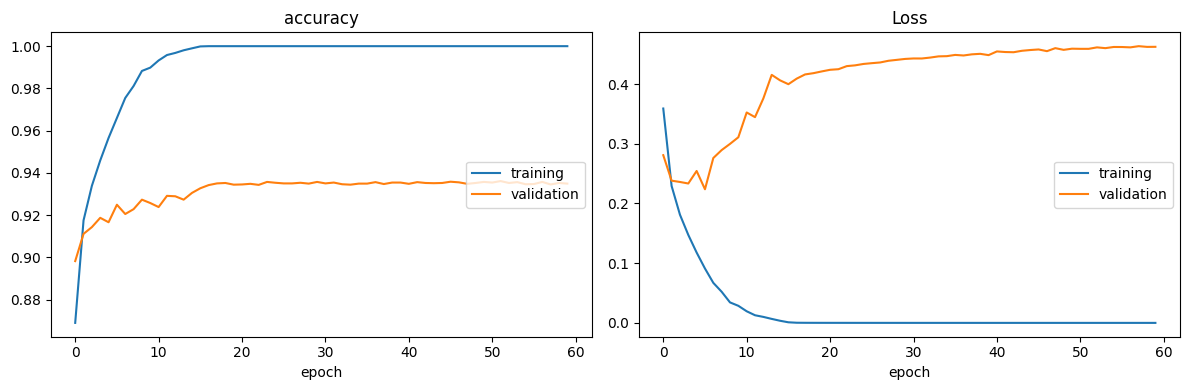

accuracy
	training         	 (min:    0.869, max:    1.000, cur:    1.000)
	validation       	 (min:    0.898, max:    0.936, cur:    0.935)
Loss
	training         	 (min:    0.000, max:    0.359, cur:    0.000)
	validation       	 (min:    0.224, max:    0.463, cur:    0.462)


In [ ]:
seed_everything(41)

model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_batch_norm=True, dropout_rate=0.0)

# Train the model with LR scheduler.
train_acc_exp3, train_loss_exp3, valid_acc_exp3, valid_loss_exp3 = main(model, data_augmentation=False, use_scheduler=True)

### 7.3 Experiment 4 - With Only Spatial-Dropout [M]

Next, we see the effect of using only Spatial Dropout in the feature extractor and regular Dropout for the "linear" layers and check their effects on training.

In [ ]:
model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_spatial_dropout=True, spatial_dropout_rate=0.2, dropout_rate=0.2)

# Printing model summary
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
MediumModel                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Dropout2d: 2-3                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          73,856
│    └─ReLU: 2-6                         [1, 128, 14, 14]          --
│    └─Dropout2d: 2-7                    [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-8                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-9                       [1, 256, 7, 7]            295,168
│    └─ReLU: 2-10                        [1, 256, 7, 7]            --
│    └─Dropout2d: 2-11                   [1, 256, 7, 7]            --
│    

With the defined **"Dropout"** regularization values, the model is still overfitting. Still, the effect is slower and more controlled than with just batch normalization layers.

The learning curves are much better, and the validation loss is much lower.

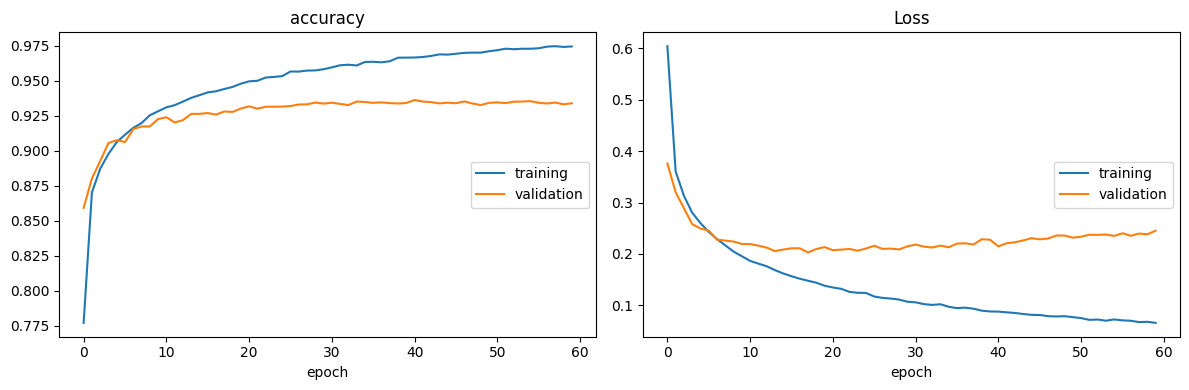

accuracy
	training         	 (min:    0.777, max:    0.975, cur:    0.974)
	validation       	 (min:    0.859, max:    0.936, cur:    0.934)
Loss
	training         	 (min:    0.066, max:    0.604, cur:    0.066)
	validation       	 (min:    0.203, max:    0.376, cur:    0.245)


In [ ]:
seed_everything(41)

model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_spatial_dropout=True, spatial_dropout_rate=0.3, dropout_rate=0.2)

# Train the model with LR scheduler.
train_acc_exp4, train_loss_exp4, valid_acc_exp4, valid_loss_exp4 = main(model, data_augmentation=False, use_scheduler=True)

### 7.4 Experiment 5 - With Batch-Norm and Dropout [M]

Let's see the effect on training when we combine both batch-norm and dropout in a single model.

In [ ]:
model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_combined=True, spatial_dropout_rate=0.3, dropout_rate=0.2)


# Printing model summary
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
MediumModel                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2dNormActivation: 2-1         [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                  [1, 64, 28, 28]           576
│    │    └─BatchNorm2d: 3-2             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-3                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-2                    [1, 64, 14, 14]           --
│    └─Conv2dNormActivation: 2-3         [1, 128, 14, 14]          --
│    │    └─Conv2d: 3-4                  [1, 128, 14, 14]          73,728
│    │    └─BatchNorm2d: 3-5             [1, 128, 14, 14]          256
│    │    └─ReLU: 3-6                    [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-4                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-5                       [1, 256, 7, 7]            295,168
│  

When both batch-normalization and dropout regularization techniques are combined, the model overfits again. There's a very minor improvement in the validation accuracy (+0.001). But there's a significant improvement in the validation loss.


The final validation loss lies in the middle of the two, indicating it's the best of both worlds.

```
With Batch Norm: Validation Loss ==> 0.462
With Dropout:    Validation Loss ==> 0.245
With Combined:   Validation Loss ==> 0.393
```

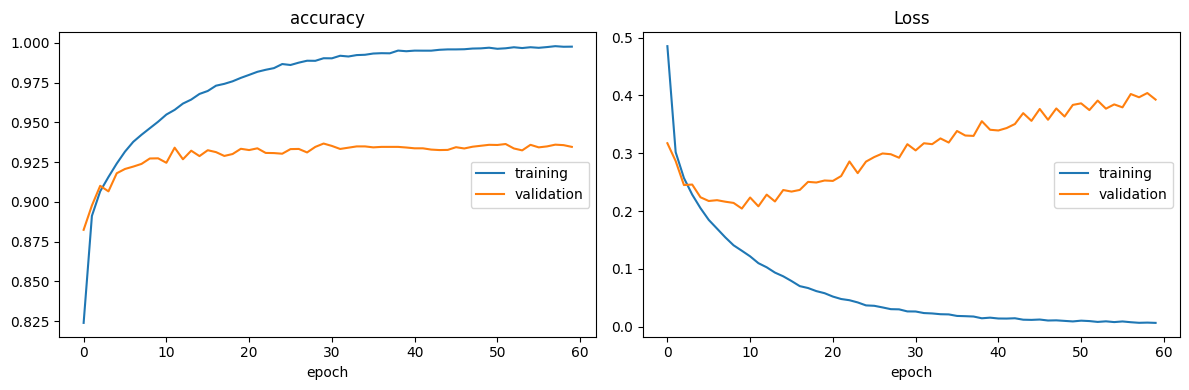

accuracy
	training         	 (min:    0.824, max:    0.998, cur:    0.998)
	validation       	 (min:    0.882, max:    0.937, cur:    0.935)
Loss
	training         	 (min:    0.006, max:    0.485, cur:    0.006)
	validation       	 (min:    0.204, max:    0.404, cur:    0.393)


In [ ]:
seed_everything(41)

model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_combined=True, spatial_dropout_rate=0.3, dropout_rate=0.2)

# Train the model with LR scheduler.
train_acc_exp5, train_loss_exp5, valid_acc_exp5, valid_loss_exp5 = main(model, data_augmentation=False, use_scheduler=True)

### 7.5 Experiment 6 - With Only Data Augmentation [M]

In this experiment, we turn off batch-normalization and dropout layers and only use **data augmentation** as a form of regularization.

In [ ]:
model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_spatial_dropout=True, spatial_dropout_rate=0.0, dropout_rate=0.0)

# Printing model summary
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
MediumModel                              [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Dropout2d: 2-3                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 128, 14, 14]          73,856
│    └─ReLU: 2-6                         [1, 128, 14, 14]          --
│    └─Dropout2d: 2-7                    [1, 128, 14, 14]          --
│    └─MaxPool2d: 2-8                    [1, 128, 7, 7]            --
│    └─Conv2d: 2-9                       [1, 256, 7, 7]            295,168
│    └─ReLU: 2-10                        [1, 256, 7, 7]            --
│    └─Dropout2d: 2-11                   [1, 256, 7, 7]            --
│    

With only data augmentation as a form of regularization, the model performs much better than the previous experiments. This tells us that for this dataset (and in general), data augmentation is an excellent form of regularization and should be part of every practitioner's arsenal.

The validation loss and accuracy both are better than the previous experiments.

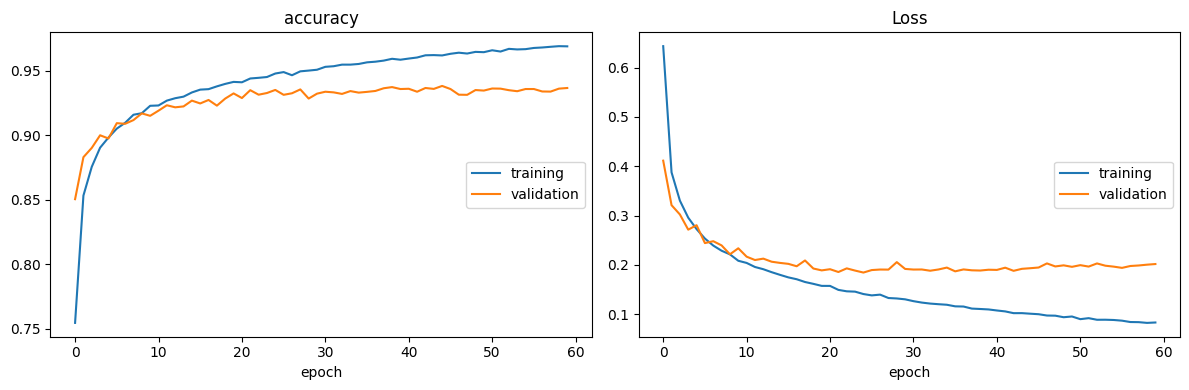

accuracy
	training         	 (min:    0.754, max:    0.969, cur:    0.969)
	validation       	 (min:    0.850, max:    0.938, cur:    0.937)
Loss
	training         	 (min:    0.082, max:    0.644, cur:    0.083)
	validation       	 (min:    0.184, max:    0.411, cur:    0.202)


In [ ]:
seed_everything(41)

model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_spatial_dropout=True, spatial_dropout_rate=0.0, dropout_rate=0.0)


# Train the model with LR scheduler.
train_acc_exp6, train_loss_exp6, valid_acc_exp6, valid_loss_exp6 = main(model, data_augmentation=True, use_scheduler=True)

### 7.6 Experiment 7 - Data Augmentation with Batch-Norm and Dropout [M]

Let's combine all three techniques, i.e., data augmentation, batch normalization, and dropout.

With the combined regularization effect, the learning curves are the best so far. Though the training loss and accuracy are better than on the validation set, the difference is minimal, and the model can be said to perform better on unseen data and thus is a "generalized" model.

Combining the three techniques is a good choice for training more deep learning models.

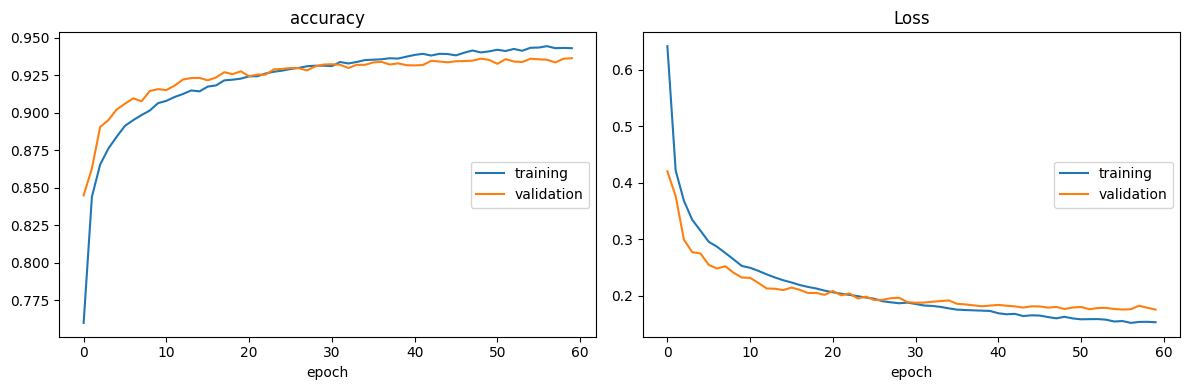

accuracy
	training         	 (min:    0.760, max:    0.944, cur:    0.943)
	validation       	 (min:    0.845, max:    0.936, cur:    0.936)
Loss
	training         	 (min:    0.151, max:    0.642, cur:    0.153)
	validation       	 (min:    0.175, max:    0.420, cur:    0.175)


In [ ]:
seed_everything(41)

model = MediumModel(in_channels=DatasetConfig.CHANNELS, num_classes=DatasetConfig.NUM_CLASSES,
                    use_combined=True, spatial_dropout_rate=0.3, dropout_rate=0.2)

# Train the model with LR scheduler.
train_acc_exp7, train_loss_exp7, valid_acc_exp7, valid_loss_exp7 = main(model, data_augmentation=True, use_scheduler=True)

## 8 Model 3 - Large Model [L]

In the  final step, let's take a larger model and see if we can further  improve the metrics.

In [ ]:
class LargeModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, spatial_dropout_rate=0.15, dropout_rate=0.2):
        super().__init__()

        self._model = nn.Sequential(

            Conv2dNormActivation(in_channels=in_channels, out_channels=64, kernel_size=3, padding='same'),
            Conv2dNormActivation(in_channels=64, out_channels=64, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),

            Conv2dNormActivation(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            Conv2dNormActivation(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),

            Conv2dNormActivation(in_channels=128, out_channels=256, kernel_size=3, padding='same'),
            Conv2dNormActivation(in_channels=256, out_channels=256, kernel_size=3, padding='same'),
            nn.MaxPool2d(kernel_size=2),

            Conv2dNormActivation(in_channels=256, out_channels=512, kernel_size=3, padding='same'),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=spatial_dropout_rate),

            nn.MaxPool2d(kernel_size=2),

            # nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Flatten(),
            nn.Linear(in_features=512, out_features=256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),

            nn.Linear(in_features=128, out_features=num_classes)
        )

    def forward(self, x):
        x = self._model(x)
        return x

In [ ]:
model = LargeModel(spatial_dropout_rate=0.0, dropout_rate=0.0)

# Printing model summary
summary(model, input_size=(1, DatasetConfig.CHANNELS, DatasetConfig.HEIGHT, DatasetConfig.WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
LargeModel                               [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2dNormActivation: 2-1         [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-1                  [1, 64, 28, 28]           576
│    │    └─BatchNorm2d: 3-2             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-3                    [1, 64, 28, 28]           --
│    └─Conv2dNormActivation: 2-2         [1, 64, 28, 28]           --
│    │    └─Conv2d: 3-4                  [1, 64, 28, 28]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 28, 28]           128
│    │    └─ReLU: 3-6                    [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 64, 14, 14]           --
│    └─Conv2dNormActivation: 2-4         [1, 128, 14, 14]          --
│    │    └─Conv2d: 3-7                  [1, 128, 14, 14]          73,728
│   

### 8.1 Perform Overfitting Check

* [x] Regularization turned off
* [x] Loss going Down
* [x] Overfitting on Single Batch

  Epoch   |     Loss      |   Acc    
   500    |  0.00000554   |  1.000   


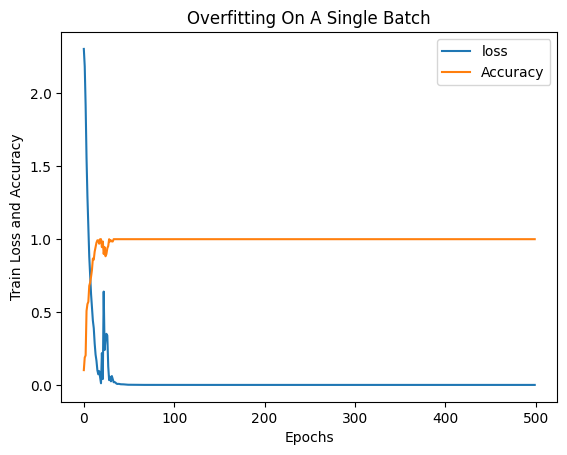

Mean loss: 0.03516122857506889, Min loss: 5.542252438317519e-06


In [ ]:
overfit_one_batch(model, total_epochs=500)

### 8.2 Experiment 8: Data Augmentation With Batch-Norm and Dropout [L]

With a larger model, we achieve the best accuracy (`0.948`) of all the experiments so far.

The validation loss suggests that any further training will lead to futher drift and lead to overfitting.

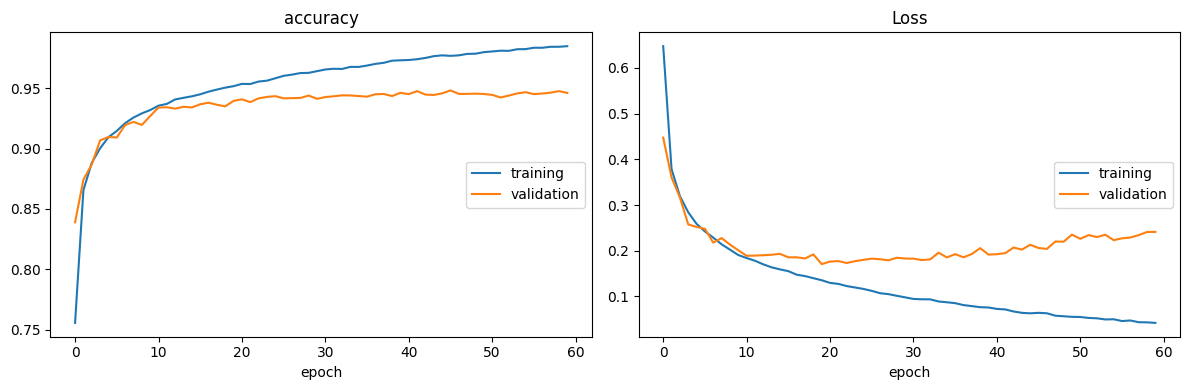

accuracy
	training         	 (min:    0.756, max:    0.985, cur:    0.985)
	validation       	 (min:    0.839, max:    0.948, cur:    0.946)
Loss
	training         	 (min:    0.042, max:    0.647, cur:    0.042)
	validation       	 (min:    0.171, max:    0.448, cur:    0.241)


In [ ]:
seed_everything(41)

model = LargeModel(spatial_dropout_rate=0.3, dropout_rate=0.3)

# Train the model with LR scheduler.
train_acc_exp8, train_loss_exp8, valid_acc_exp8, valid_loss_exp8 = main(model, data_augmentation=True, use_scheduler=True)

You can try to reduce it by:
1. Using more data augmenetation
2. Testing w/wo LR scheduler or using a Cyclic LR scheduler (with restarts)
3. Increasing dropout power.
4. Choosing which layers to apply dropout and  batch normalization
5. Reducing number of parameters
6. Adding weight contraints (L1, L2, max-norm)
7. Early stopping

## 9 Plotting Accuracy & Loss Curves

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None):
    fig, ax = plt.subplots(figsize=(16, 6))
    ax.set_facecolor("white")

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric)

    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel(ylabel, fontsize=18)
    plt.title(ylabel + " per Epoch", fontsize=22)
    plt.xlim([0, TrainingConfig.NUM_EPOCHS - 1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name, loc="best", fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{ylabel}.png")
    plt.show()
    plt.close()

Abbreviations:

* **NO** - No regularization
* **BN** - Using only BatchNorm layer used.
* **DR** - Using only Dropout regulaization.
* **CO** - Using both BatchNorm and Dropout regulaization.
* **DA** - With data augmentation applied.
* **DA+CO** - Using all three techniques - Data Augmentation + BatchNorm + Dropout


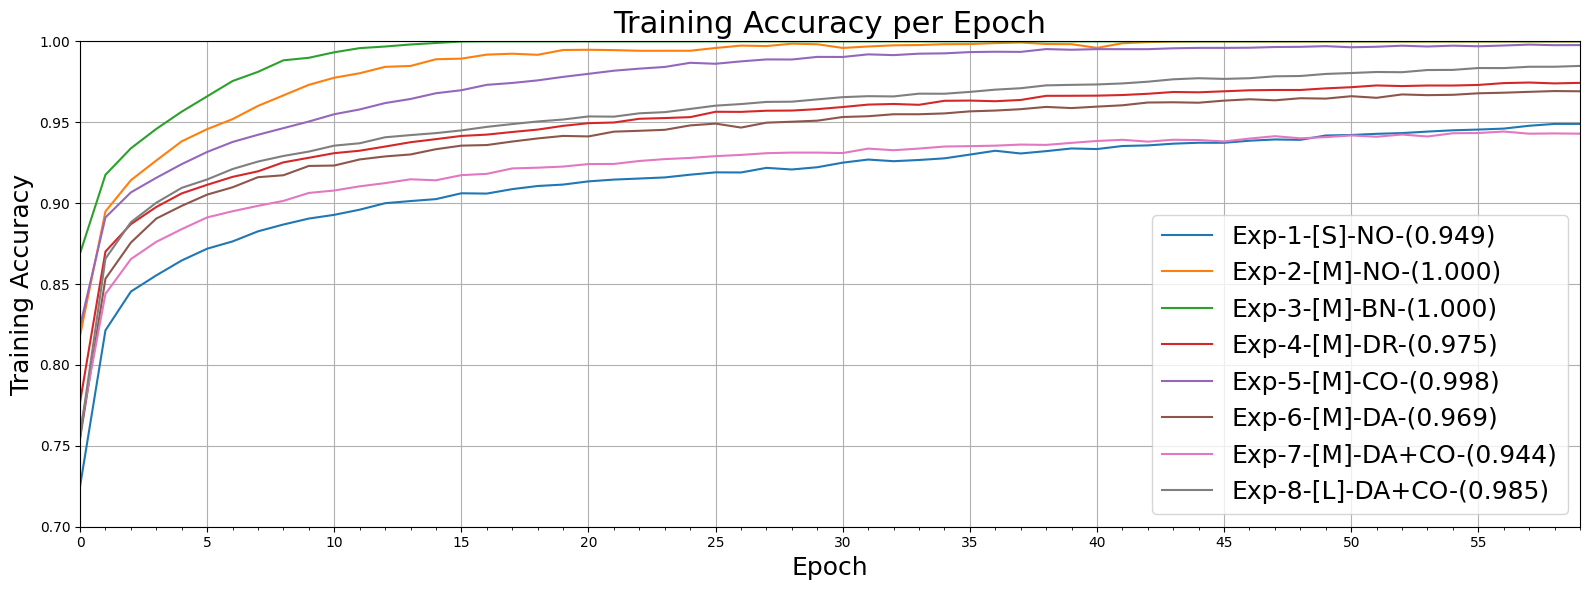

In [ ]:
plot_results(
    [train_acc_exp1, train_acc_exp2, train_acc_exp3, train_acc_exp4, train_acc_exp5, train_acc_exp6, train_acc_exp7, train_acc_exp8],
    ylabel="Training Accuracy",
    ylim=[0.7, 1.0],
    metric_name=[
        f"Exp-1-[S]-NO-({max(train_acc_exp1):.3f})",
        f"Exp-2-[M]-NO-({max(train_acc_exp2):.3f})",
        f"Exp-3-[M]-BN-({max(train_acc_exp3):.3f})",
        f"Exp-4-[M]-DR-({max(train_acc_exp4):.3f})",
        f"Exp-5-[M]-CO-({max(train_acc_exp5):.3f})",
        f"Exp-6-[M]-DA-({max(train_acc_exp6):.3f})",
        f"Exp-7-[M]-DA+CO-({max(train_acc_exp7):.3f})",
        f"Exp-8-[L]-DA+CO-({max(train_acc_exp8):.3f})"],
)

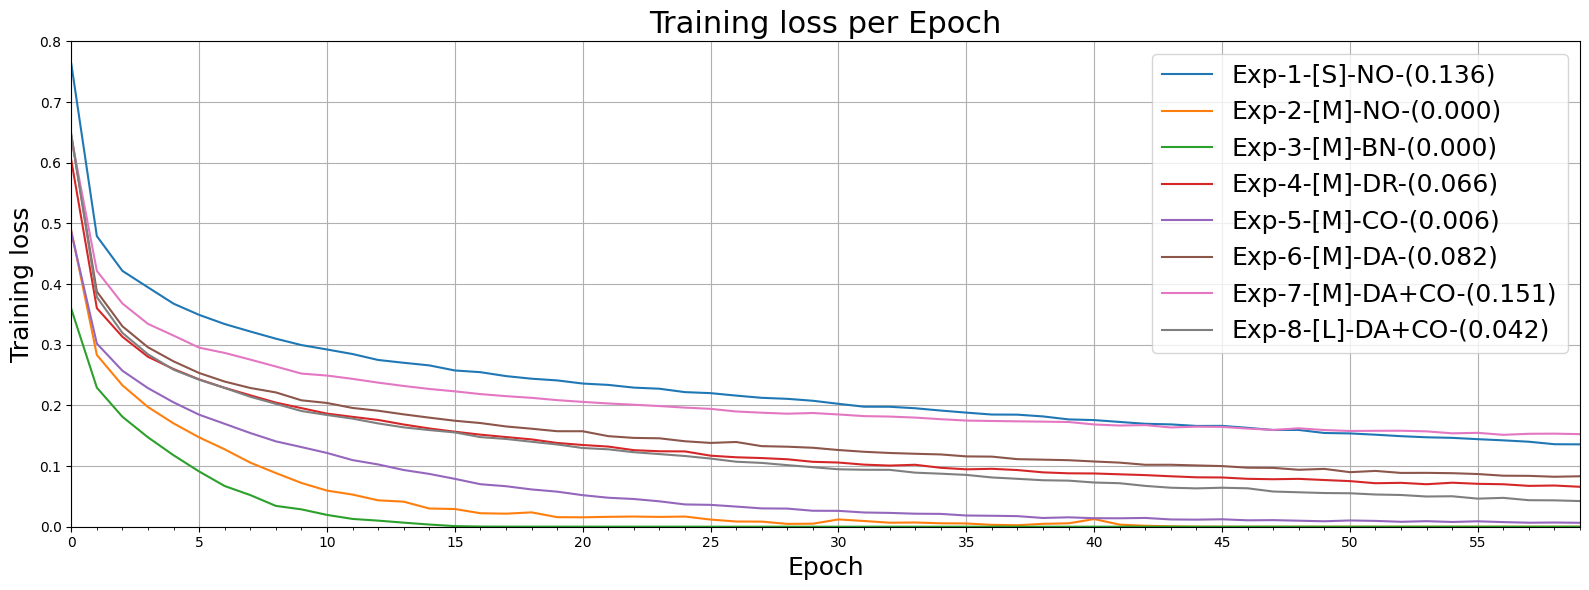

In [ ]:
plot_results(
    [train_loss_exp1, train_loss_exp2, train_loss_exp3, train_loss_exp4, train_loss_exp5, train_loss_exp6, train_loss_exp7, train_loss_exp8],
    ylabel="Training loss",
    ylim=[0.0, 0.8],
    metric_name=[
        f"Exp-1-[S]-NO-({min(train_loss_exp1):.3f})",
        f"Exp-2-[M]-NO-({min(train_loss_exp2):.3f})",
        f"Exp-3-[M]-BN-({min(train_loss_exp3):.3f})",
        f"Exp-4-[M]-DR-({min(train_loss_exp4):.3f})",
        f"Exp-5-[M]-CO-({min(train_loss_exp5):.3f})",
        f"Exp-6-[M]-DA-({min(train_loss_exp6):.3f})",
        f"Exp-7-[M]-DA+CO-({min(train_loss_exp7):.3f})",
        f"Exp-8-[L]-DA+CO-({min(train_loss_exp8):.3f})"],
)

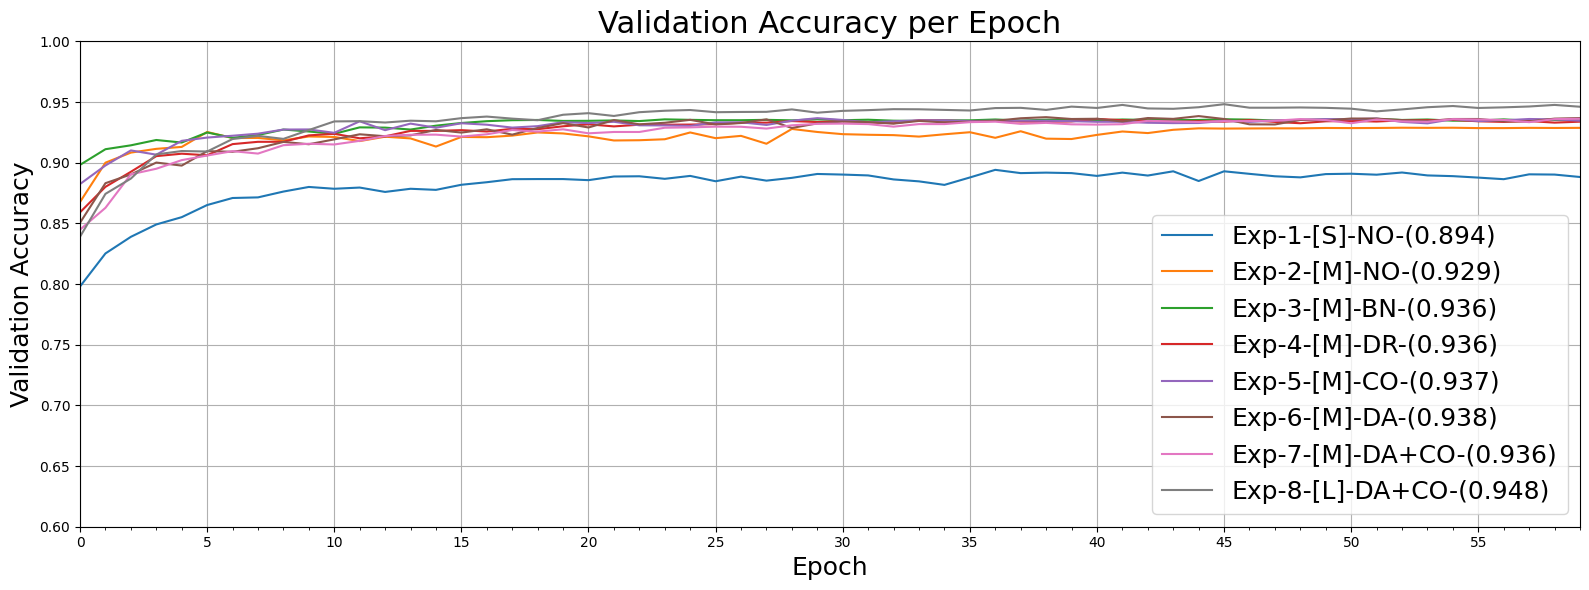

In [ ]:
plot_results(
    [valid_acc_exp1, valid_acc_exp2, valid_acc_exp3, valid_acc_exp4, valid_acc_exp5, valid_acc_exp6, valid_acc_exp7, valid_acc_exp8],
    ylabel="Validation Accuracy",
    ylim=[0.6, 1.0],
    metric_name=[
        f"Exp-1-[S]-NO-({max(valid_acc_exp1):.3f})",
        f"Exp-2-[M]-NO-({max(valid_acc_exp2):.3f})",
        f"Exp-3-[M]-BN-({max(valid_acc_exp3):.3f})",
        f"Exp-4-[M]-DR-({max(valid_acc_exp4):.3f})",
        f"Exp-5-[M]-CO-({max(valid_acc_exp5):.3f})",
        f"Exp-6-[M]-DA-({max(valid_acc_exp6):.3f})",
        f"Exp-7-[M]-DA+CO-({max(valid_acc_exp7):.3f})",
        f"Exp-8-[L]-DA+CO-({max(valid_acc_exp8):.3f})"],
)

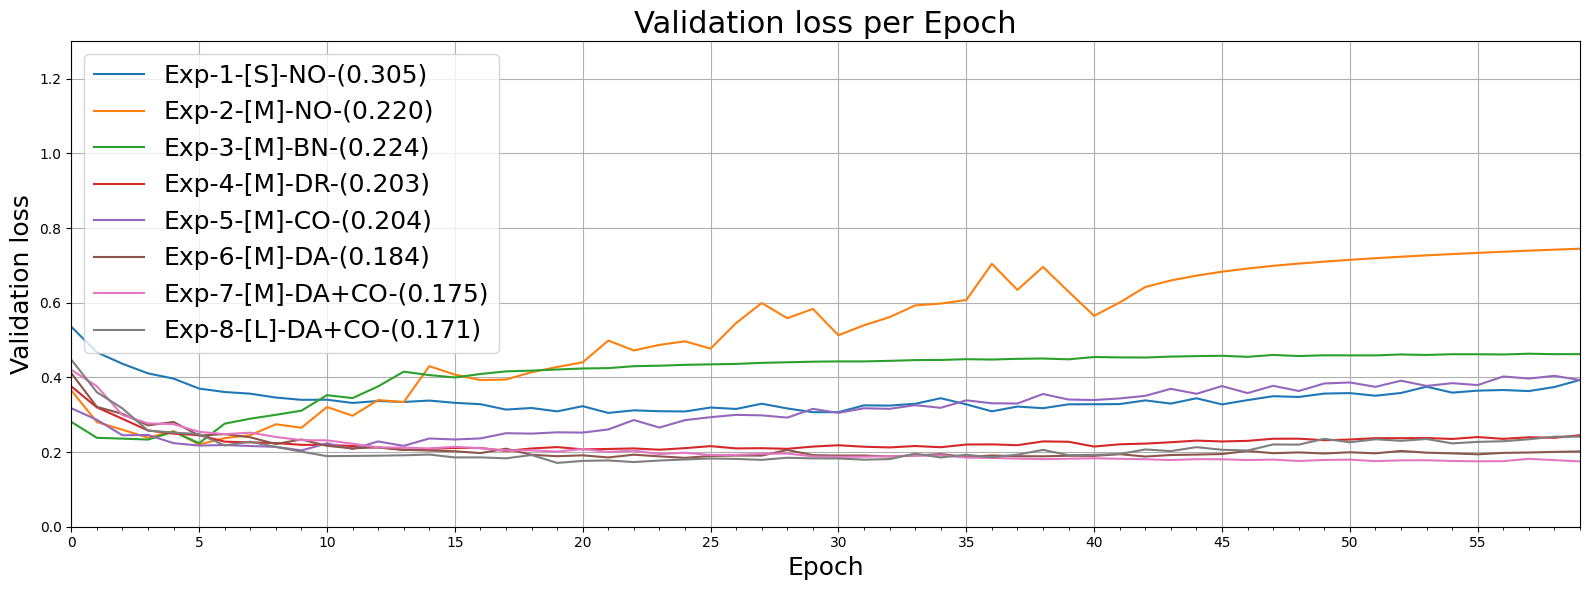

In [ ]:
plot_results(
    [valid_loss_exp1, valid_loss_exp2, valid_loss_exp3, valid_loss_exp4, valid_loss_exp5, valid_loss_exp6, valid_loss_exp7, valid_loss_exp8],
    ylabel="Validation loss",
    ylim=[0.0, 1.3],
    metric_name=[
        f"Exp-1-[S]-NO-({min(valid_loss_exp1):.3f})",
        f"Exp-2-[M]-NO-({min(valid_loss_exp2):.3f})",
        f"Exp-3-[M]-BN-({min(valid_loss_exp3):.3f})",
        f"Exp-4-[M]-DR-({min(valid_loss_exp4):.3f})",
        f"Exp-5-[M]-CO-({min(valid_loss_exp5):.3f})",
        f"Exp-6-[M]-DA-({min(valid_loss_exp6):.3f})",
        f"Exp-7-[M]-DA+CO-({min(valid_loss_exp7):.3f})",
        f"Exp-8-[L]-DA+CO-({min(valid_loss_exp8):.3f})"],
)

## 10 Conclusion

When performing deep learning experiments, we should start a simple model and check if it quickly passes the overfitting test and overfits the training data.

Once the check is completed and we have a model which we are confident can fit the chosen dataset, start adding regularization techniques one-by-one and check their effects and adjust their strength accordingly.

If the results are not satisfactory, change the model and experiment again.


As an exercise, you can take any other dataset, like cifar-10, cifar-100, etc., to perform your own experiments or a dataset with larger images.

Experimentation is a big part of deep learning. The more you experiment, you'll gain more hands-on training and experience, which will reduce the learning curve when trying out new techniques.